<a href="https://colab.research.google.com/github/JawnMarc/cifar-10-custom-image-classifier/blob/main/CIFAR_10_on_Pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [ ]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from collections import  OrderedDict


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
n_workers = 0
batch_size = 20


# Define transforms
transform = transforms.Compose([transforms.RandomRotation(30),
                                # transforms.RandomCrop(32),
                                # transforms.RandomResizedCrop(224),
                                transforms.Resize(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


# Create training & test data set
trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/ML Research/Convolutional-neural-network/cifar-cnn/data', download=True, transform=transform, train=True)
testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/ML Research/Convolutional-neural-network/cifar-cnn/data', download=True, transform=test_transform, train=False)


# Spilt 20% of training set for validation set
valid_data_size = 0.2

train_len = len(trainset)
indices = list(range(train_len))
np.random.shuffle(indices)

split = int(np.floor(valid_data_size * train_len))
train_idx, valid_idx = indices[split:], indices[:split]


# Samplers to obtain training and validation batches
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Define train, valid & test dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler,
                                          num_workers=n_workers)

validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler,
                                          num_workers=n_workers)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=n_workers)


# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print('\nDATASET LENGTH:\nTrain Dataset: {} \nTest Dataset: {}\n'.format(
    len(trainset), len(testset)))
print('DATALOADER LENGTH (For each batch size of {}):\nTrainloader: {}\nValidloader: {}\nTestloader: {}'.format(
    batch_size ,len(trainloader), len(validloader), len(testloader)))


Extracting /content/drive/MyDrive/ML Research/Convolutional-neural-network/cifar-cnn/data/cifar-10-python.tar.gz to /content/drive/MyDrive/ML Research/Convolutional-neural-network/cifar-cnn/data
Files already downloaded and verified

DATASET LENGTH:
Train Dataset: 50000 
Test Dataset: 10000

DATALOADER LENGTH (For each batch size of 20):
Trainloader: 2000
Validloader: 500
Testloader: 500


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [ ]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]

    for i in range(5):
        print(classes[labels[i]])

        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()


def show10_unnormalized(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:10]
    images = batch[0][0:10]

    for i in range(10):
        print(classes[labels[i]])

        # unnormalize
        image  = images[i]/2 + .5
        image = image.numpy()

        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

In [ ]:
# Explore data

def show_data_dim(dataloader):
    data_iter = iter(dataloader)
    imgs, label = data_iter.next()
    imgs = imgs.numpy()
    return imgs, label

train_img, _ = show_data_dim(trainloader)

print('Training Data size:\n{}\n'.format(train_img.size))
print('Training Data shape:\n{}'.format(train_img.shape))

Training Data size:
3010560

Training Data shape:
(20, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


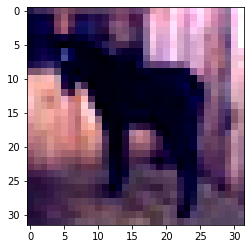

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


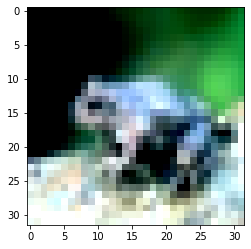

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


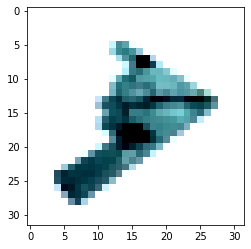

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


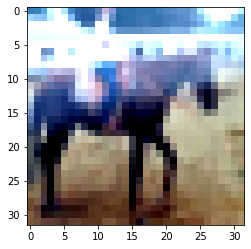

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bird


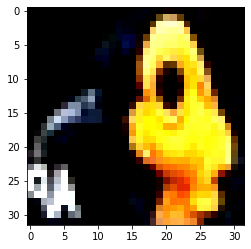

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


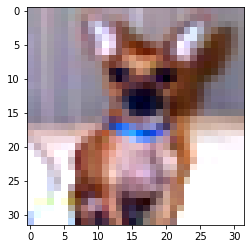

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


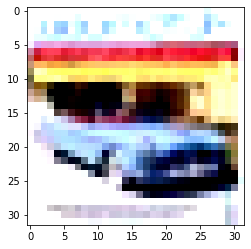

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer


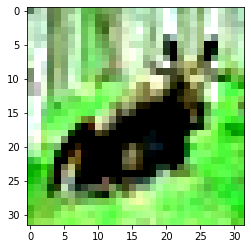

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


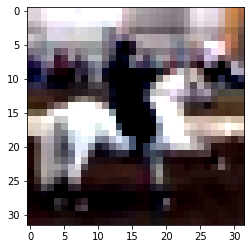

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


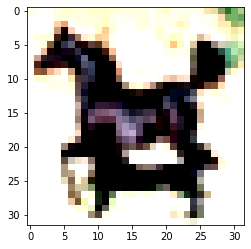

In [ ]:
# Show 10 random test set image samples
show10_unnormalized(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [ ]:
# ## YOUR CODE HERE ##
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         ''' Builds a network with 3 convultional layers and feedforward network with one hidden layer.'''

#         super(NeuralNetwork, self).__init__()
#         # convolutional layers
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
#         # max pooling layer 
#         self.pool = nn.MaxPool2d(2, 2)
        
#         # linear layers
#         self.fc1 = nn.Linear(64 * 4 * 4, 512)
#         self.fc2 = nn.Linear(512, 10)
         
#         # dropout layer   
#         self.dropout = nn.Dropout(0.45)
        
        
#     def forward(self, x):
#         ''' Forward pass through the network, returns logits output probs '''
        
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
     
#         # flatten image input        
#         x = x.view(-1, 64 * 4 * 4)
#         x = self.dropout(x)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
        
#         # output layer
#         x = self.fc2(x)

#         return x

In [ ]:
# # Initiate Neural Network
# model = NeuralNetwork()
# print(model)

# Using a pre-trained model


In [ ]:
# model = models.resnet152(pretrained=True)
# model = models.resnet34(pretrained=True)
# model = models.vgg19(pretrained=True)
model = models.densenet121(pretrained=True)


# freeze paramters
for param in model.parameters():
    param.requires_grad = False

print(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
# in_feature = model.fc.in_features
# in_feature = model.classifier[0].in_features
in_feat = model.classifier.in_features
# print(in_feat)

custom_classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(in_feat, 386)),
        ('relu', nn.ReLU()),
        ('dropout', nn.Dropout()),
        ('fc2', nn.Linear(386, 10))
]))


model.classifier = custom_classifier
# model

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [ ]:
# CrossEntropyLoss function to apply softmax to the output layer 
# to convert logits to probs
criterion = nn.CrossEntropyLoss()
# model param frozen, training classifier
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:

# Initiate CUDA GPU if found else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Paramters
Epochs = 50
valid_loss_min = np.Inf

# Initiate list for saving losses & accuracy for plot
train_loss_scores = []
valid_loss_scores = []
accuracy_scores = []

# Use checkpoint technique to save the losest min loss during trainig
checkpoint_dict = {
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'epochs': Epochs
    }


for epoch in range(1, Epochs+1):
    # track train and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0
    total = 0
    
    # model training
    model.train()
    for idx, (inputs, labels) in enumerate(trainloader):
        # move data & label to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        # clear gradients of optimized variables
        optimizer.zero_grad()
        
         # forward pass
        output = model.forward(inputs)
        loss = criterion(output, labels)
        
        # backpass and weight update
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        
    # model evaluation
    model.eval()
    for idx, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        loss = criterion(output, labels)
        valid_loss += loss.item() * inputs.size(0)
        
        # accuracy
        prediction = torch.max(output.data, 1)[1]

        total += labels.size(0)
        accuracy += (prediction == labels).sum().item()
    
    
    # calculate average train loss & validation loss
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)


    # update train_loss_scores, valid_losses_scores & accuracy_scores lists for plot
    train_loss_scores.append((train_loss))
    valid_loss_scores.append((valid_loss))
    accuracy_scores.append(100*(accuracy/total))


    # print train, valid losses & validation  accuracy
    print('Epoch: {}\{} \tTraining Loss: {:.9f} \tValidation Loss: {:.9f} \tValidation Accuracy: {:.2f}%'.format(
        epoch, Epochs, train_loss, valid_loss, 100*(accuracy/total)))


    # save model if validation loss decreases
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased from \t{:.9f} ==> {:.9f} \tSaving model ...\n'.format(
        valid_loss_min, valid_loss))

        # model checkpointing: model with lowest validation loss is saved
        torch.save(checkpoint_dict, 'small_loss_model.pth')
        # update valid_los_min
        valid_loss_min = valid_loss

Epoch: 1\10 	Training Loss: 2.116211989 	Validation Loss: 1.844749471 	Validation Accuracy: 45.95%
Validation loss decreased from 	inf ==> 1.844749471 	Saving model ...

Epoch: 2\10 	Training Loss: 1.741213773 	Validation Loss: 1.509401444 	Validation Accuracy: 53.01%
Validation loss decreased from 	1.844749471 ==> 1.509401444 	Saving model ...

Epoch: 3\10 	Training Loss: 1.534638439 	Validation Loss: 1.346803901 	Validation Accuracy: 56.26%
Validation loss decreased from 	1.509401444 ==> 1.346803901 	Saving model ...

Epoch: 4\10 	Training Loss: 1.424767108 	Validation Loss: 1.261789575 	Validation Accuracy: 58.19%
Validation loss decreased from 	1.346803901 ==> 1.261789575 	Saving model ...

Epoch: 5\10 	Training Loss: 1.356961693 	Validation Loss: 1.200804628 	Validation Accuracy: 59.37%
Validation loss decreased from 	1.261789575 ==> 1.200804628 	Saving model ...

Epoch: 6\10 	Training Loss: 1.312957313 	Validation Loss: 1.171503732 	Validation Accuracy: 60.31%
Validation loss dec

Plot the training loss (and validation loss/accuracy, if recorded).

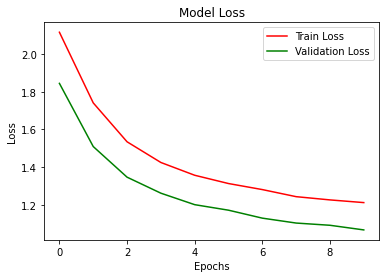

In [ ]:
# Plot train loss and valid loss scores
plt.plot(train_loss_scores,label='Train Loss', color='red')
plt.plot(valid_loss_scores, label='Validation Loss', color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

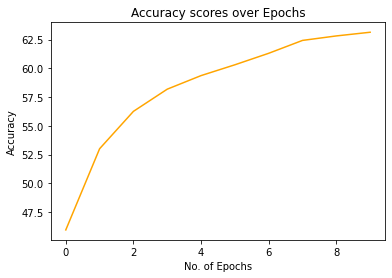

In [ ]:
# Plot accuracacy score
plt.plot(accuracy_scores, label='Accuracy score', color='orange')
plt.title('Accuracy scores over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
# track test loss
test_loss = 0
test_accuracy = 0
test_total = 0
class_correct = [0 for i in range(10)]
class_total = [0 for i in range(10)]

model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        loss = criterion(output, labels)
        test_loss += loss.item()*inputs.size(0)
        
        # convert highest output probability to predicted class
        prediction = torch.max(output, 1)[1]
        test_total += labels.size(0)
        test_accuracy += (prediction == labels).sum().item()
        
        for idx in range(batch_size):
                label = labels[idx]
                pred = prediction[idx]             
                if (label == pred):
                    class_correct[label] += 1
                class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.4f}\n'.format(test_loss))

# print accuracy for each class
for idx in range(10):
    if class_total[idx] > 0:
        print('Test Accuracy of {}\t:\t{}%'.format(
            classes[idx], 100 * class_correct[idx] / class_total[idx]))
    else:
        print('Test Accuracy of {}: N/A (no training examples)'.format(classes[idx]))

print('\nTest Accuracy (Overall)\t:\t{}%'.format(
    100. * np.sum(class_correct) / np.sum(class_total)))

Test Loss: 3.7551

Test Accuracy of plane	:	36.1%
Test Accuracy of car	:	10.2%
Test Accuracy of bird	:	48.4%
Test Accuracy of cat	:	33.2%
Test Accuracy of deer	:	31.1%
Test Accuracy of dog	:	25.1%
Test Accuracy of frog	:	21.7%
Test Accuracy of horse	:	2.5%
Test Accuracy of ship	:	31.0%
Test Accuracy of truck	:	10.5%

Test Accuracy (Overall)	:	24.98%


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
# By use of model checkpointing, the model with lowest validaiton loss
# is saved during training.

# Load saved model with lowest validation loss
# torch.save(checkpoint_dict, 'small_loss_model.pth')
print(torch.load('small_loss_model.pth'))

{'model_state': OrderedDict([('conv1.weight', tensor([[[[ 7.1679e-02, -8.4869e-01, -4.1749e-01],
          [-2.2791e-01, -1.3412e-02,  1.2820e+00],
          [ 8.4681e-02,  2.8085e-01, -2.0818e-01]],

         [[ 1.3254e-01, -7.1769e-01, -2.3978e-01],
          [-1.6321e-01,  5.9537e-02,  1.0612e+00],
          [-1.5321e-01,  4.2926e-01, -4.1204e-01]],

         [[-8.6095e-02, -1.0299e+00, -5.9194e-01],
          [-4.5653e-02,  3.7424e-01,  1.4038e+00],
          [-3.5930e-03,  6.3925e-01, -5.9206e-01]]],


        [[[ 3.4191e-01,  3.1703e-01, -1.2778e-02],
          [-2.7194e-01, -2.4118e-01,  7.3260e-03],
          [-1.7008e-01, -1.5151e-01,  1.3023e-01]],

         [[ 5.9766e-01,  6.5844e-01,  5.9802e-01],
          [-4.8771e-01,  1.8979e-02,  2.2748e-01],
          [-7.4786e-01, -5.5686e-01, -4.5762e-01]],

         [[ 3.5566e-01,  1.7545e-01, -2.7145e-02],
          [-3.8322e-02,  3.3396e-01,  2.7736e-01],
          [-2.6452e-01, -5.2904e-01, -2.5854e-01]]],


        [[[-5.1539e-

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



## RECOMMENDATION BASED ON IN-HOUSE SOLUTION

Based on the evulation of my in-house model which achieves an *excellent* accuracy of ***79.89%*** compared to Detectocorp's model, I do *recommend* we build an in-house solution and not to buy Detectocorp's algorithm.

Even though my model achieves a better accuracy compared to Detectocorp's, it is way behind the *far more advanced models shown in the articles*. Those [models boost *additional 10%-19%* accuracy](https://colab.research.google.com/drive/1D2qFmg1OW9vjEl3DEYaEbUKaz4O3WNIJ#scrollTo=vhA0YAKyrNwJ&line=11&uniqifier=1) over my model due to thier advanced techniques and fairly complex archictectures except [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf).

During the initial attempts to build the model, I observed an average accuracy of 55%-58% based on 2 convolutional layer and a fully connected network model with dropout of 25% applied in between the FC layers which was trained at 40 - 50 epochs. After several tweaking and experimenting, a 3 convolutional layer and fully connected network model with increased dropout percentage of 45% applied in between the FC layers achieved an accuracy of 79.89% training over 250 epochs.

***Is it necessary to improve this accuracy?*** No, it is not. But if need be for the in-house model to be used on more advanced scenarios which requires high precision accuracy then in-house model could further be experimented with using the techniques or approaches found in the articles to improves accuracy. Aside tweaking the hyperparameters, applying *Batch Normalization* after each convulational layer could improve models accuracy even better. Experimenting with the order of activations functions between convolutions layer could also bring some gains in the accuracy.Training for longer times could also improve accuracy if it doesn't cause model overfitting.



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).

### References
* [1] [PyTorch Tutorial: Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network)
* [2] [Improving your Deep Learning model using Model Checkpointing- Part 1](  https://www.analyticsvidhya.com/blog/2021/03/improving-your-deep-learning-model-using-model-checkpointing-part-1/ )
* [3] [Common Loss function in Machine Learning for Classification Models](  https://medium.com/analytics-vidhya/common-loss-functions-in-machine-learning-for-classification-model-931cbf564d42 )
* [4] [Pytorch Cross Entropy Loss source code](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

* [5] [How to display graphs of loss and accuracy on pytorch using matplotlib](https://stackoverflow.com/questions/63106109/how-to-display-graphs-of-loss-and-accuracy-on-pytorch-using-matplotlib)

* [6] [Udacity: Intro to Deep Learning with PyTorch | Convolutional Neural Networks](https://classroom.udacity.com/courses/ud188#)
